In [58]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
random.seed()

In [ ]:
# Set vehicle limitations. They all have same capacity of 20k kg and 10 m3
truckKg = 20000
truckVol = 20
truckSpd = 0.6

In [ ]:
# loading data

customersDf = pd.read_excel("data/2_detail_table_customers.xls")
depotsDf = pd.read_excel("data/4_detail_table_depots.xls")
trucksDf = pd.read_excel("data/3_detail_table_vehicles.xls")
routes = customersDf["ROUTE_ID"].unique()

In [ ]:
routes

array([2946091, 2922001, 2939484, 2958047, 2970877, 2990001, 3005971,
       2604001, 3016355, 3027038, 3044702])

In [ ]:
def getData(route, customersDf, depotsDf, trucksDf):
  '''Returns Number of Trucks, List of Customers, Cost, Demand For all Customers'''
  C_df = customersDf[customersDf['ROUTE_ID'] == route].set_index("CUSTOMER_NUMBER",drop=False).copy()
  D_df = depotsDf[depotsDf['ROUTE_ID'] == route].reset_index()

  # Grabbing the amount of trucks available for each route
  numberOfTrucks = trucksDf[trucksDf['ROUTE_ID'] == route]['VEHICLE_NUMBER'].max()

  # truckCapacityKg = 20000
  # truckCapacityVolume = 10

  # Getting id for each customer and then adding the starting node (depot). this will be used to calculate distance
  customersId = list(C_df['CUSTOMER_NUMBER'].unique())
  V = [0]+ customersId

  # Those represent the edges
  edges = [(i,j) for i in V for j in V if i != j]

  # This function gives back a dictionary that represents an edge from i to j, keys of the dictionary, and its value is the cost (time taken to travel from i to j)
  cost = getCostDict(C_df, D_df, edges)
  # This represents the demand of each customer i = (weight, volume)
  demandForCustomer = {i : (C_df.loc[i,"TOTAL_WEIGHT_KG"],C_df.loc[i,"TOTAL_VOLUME_M3"]) for i in C_df.index.to_list()}
  return (numberOfTrucks,customersId, cost, demandForCustomer)

In [ ]:
def getCostDict(customers,depot, edges):
  '''This function returns a cost dict '''
  cost = {}
  depot_lat, depot_lon = depot.loc[0,"DEPOT_LATITUDE"], depot.loc[0,"DEPOT_LONGITUDE"]
  for (loc1, loc2) in edges:
    # Depot
    if loc1 == 0:
      cost[(loc1,loc2)] = round(np.hypot(depot_lat - customers.loc[loc2,"CUSTOMER_LATITUDE"],
                                   depot_lon - customers.loc[loc2,"CUSTOMER_LONGITUDE"])/truckSpd,4)
    elif loc2 == 0:
      cost[(loc1,loc2)] = round(np.hypot(depot_lat - customers.loc[loc1,"CUSTOMER_LATITUDE"],
                                   depot_lon - customers.loc[loc1,"CUSTOMER_LONGITUDE"])/truckSpd,4)
    else:
      cost[(loc1,loc2)] = round(np.hypot(customers.loc[loc1,"CUSTOMER_LATITUDE"] - customers.loc[loc2,"CUSTOMER_LATITUDE"],
                                   customers.loc[loc1,"CUSTOMER_LONGITUDE"] - customers.loc[loc2,"CUSTOMER_LONGITUDE"])/truckSpd,4)
  return cost

In [ ]:
customersDf[customersDf['ROUTE_ID'] == 2946091]

,ROUTE_ID,CUSTOMER_NUMBER,CUSTOMER_CODE,CUSTOMER_LATITUDE,CUSTOMER_LONGITUDE,CUSTOMER_TIME_WINDOW_FROM_MIN,CUSTOMER_TIME_WINDOW_TO_MIN,NUMBER_OF_ARTICLES,TOTAL_WEIGHT_KG,TOTAL_VOLUME_M3,CUSTOMER_DELIVERY_SERVICE_TIME_MIN,
0,2946091,1,138087,43.413050,17.875880,480,900,42.0,64.318,0.320,19.94,
1,2946091,2,138157,43.135963,17.776839,480,900,14.0,17.553,0.046,11.36,
2,2946091,3,26,43.469078,17.337022,481,961,4.0,6.378,0.041,8.73,
3,2946091,4,478,43.707160,17.222900,481,961,5.0,16.375,0.046,9.10,
4,2946091,5,921127,43.082228,17.960037,480,840,16.0,18.939,0.074,11.99,
...,...,...,...,...,...,...,...,...,...,...,...,...
102,2946091,103,1676,43.109400,17.703620,481,961,3.0,0.598,0.002,8.26,
103,2946091,104,1805,43.381760,17.591550,481,961,8.0,172.647,0.523,13.32,
104,2946091,105,923762,43.715555,17.230788,481,961,4.0,25.716,0.149,9.36,
105,2946091,106,140023,43.469840,17.322420,481,961,7.0,87.056,0.111,10.54,


## Genetic Algorithm Utils


In [ ]:
def _canAddCustomerToTruck(truck,truckCapacityKg,truckCapacityVol,singleDemand,allCustomersDemands):
  ''' This function just checks if it's possible to add the delivery of someone into a truck'''
  total_weight = sum(allCustomersDemands[customer][0] for customer in truck if customer != 0) + singleDemand[0]
  total_volume = sum(allCustomersDemands[customer][1] for customer in truck if customer != 0)+ singleDemand[1]
  return total_weight <= truckCapacityKg and total_volume <= truckCapacityVol

In [ ]:
def initializePopulation(population_size,numberOfTrucks,customers,demandForCustomer):
  '''This function just initializes and returns a starting population array while keeping the constraints in mind'''
  population = []
  random.seed()

  # Keeps increasing population
  for i in range(population_size):
    trucks = [[0] for _ in range(numberOfTrucks)]
    remainingCustomers = set(customers)

    # While there are customers remaining, try to assign them to a truck
    while remainingCustomers:
      for truck in trucks:
        # Early break to avoid unnecessary iteration
        if not remainingCustomers:
          break

        # Choose a customer at random and see if its demand fits
        customerChosen = random.choice(list(remainingCustomers))
        demand = demandForCustomer[customerChosen]

        # If it does, add it to the truck and remove it from the remainingCustomers set.
        if _canAddCustomerToTruck(truck,truckKg,truckVol,demand,demandForCustomer):
          truck.append(customerChosen)
          remainingCustomers.remove(customerChosen)
    # Add 0 at the end -> go home to depot:
    for truck in trucks:
      if len(truck) > 1: # If it has at least one customer
        truck.append(0)

    population.append(trucks)

  return population


In [ ]:
trucksNo, customers, cost, demand = getData(2946091,customersDf,depotsDf,trucksDf)

In [ ]:
def calculate_route_cost(route,cost):
  ''' This function calculates total route cost in terms of time '''
  totalCost = 0
  for i in range(len(route) - 1):
    edge = (route[i], route[i+1])
    totalCost += cost[edge]
  return totalCost

In [ ]:
def fitnessFunction(solution, cost):
  '''Returns total cost of a solution'''
  totalCost = 0
  for route in solution:
    totalCost += calculate_route_cost(route, cost)
  return totalCost

In [ ]:
def tournamentSelection(population,tournament_size,mating_pool_size, fitnessScores):
  # Calculate fitness function for every individual in the population
  # fitnessScores = []
  # for individual in population:
  #   fitnessScores.append(fitnessFunction(individual,cost))

  matingPool = []


  while len(matingPool) < mating_pool_size:
    battle = random.sample(list(zip(population,fitnessScores)), tournament_size)

    # winner will be the one with the least amount of cost. he will be selected for the mating pool
    winner = min(battle,key=lambda x: x[1])

    #This intentionally allows multiple individuals from entering the mating_pool
    matingPool.append(winner[0])

  return matingPool



Now this part is tricky because we are dealing with multiple trucks. To do so, I decided to flat out all the trucks and apply the order crossover there. After that, I 'unflat' it and apply the constraints of weight and volume

In [ ]:
### Order CrossOver:
# In this approach, we select 2 points in the parent sequences to define a child.

def flatten(routes):
  return [node for route in routes for node in route[1:-1]] # Not interested in the 0


def orderCrossover(parent1,parent2):
  dad = flatten(parent1)
  mom = flatten(parent2)
  child1 = [None]*len(dad)
  child2 = [None]*len(dad)

  # This gets 2 random indices where cx1 is always the smaller and cx2 the bigger
  cx1, cx2 = sorted(random.sample(range(len(dad)), 2))

  # Child inheritence from dad and mom
  child1[cx1:cx2+1] = dad[cx1:cx2+1]
  child2[cx1:cx2+1] = mom[cx1:cx2+1]

  # Inherent from mom and dad

  position = 0
  for node in mom:
    # If position is cx1, that means it has already gotten the node from the father
    if position == cx1:
      position = cx2 + 1

  # Just double checking to make sure it stays correct (only 1 visit per node)
    if node not in child1:
      child1[position] = node
      position += 1

  position = 0
  for node in dad:
    # same thing to the dad.
    if position == cx1:
      position = cx2 + 1
    if node not in child2:
      child2[position] = node
      position += 1

  return child1, child2

def reconstruct_routes(flat_sequence, truckCapacityKg, truckCapacityVolume, demandForCustomer,numberOfTrucks):
    '''This function is to just recover the sequence after flattening it'''
    # routes = []
    # current_route = [0]
    # current_weight, current_volume = 0, 0
    trucks = [[0]*numberOfTrucks]
    customerRemaining = flat_sequence.copy()
    while customerRemaining:
      for i in range(len(trucks)):
        if not customerRemaining:
          break
        customerChosen = customerRemaining[0]
        demand = demandForCustomer[customerChosen]

        if _canAddCustomerToTruck(trucks[i],truckKg,truckVol,demand,demandForCustomer):
          truck.append(customerChosen)
          customerRemaining.pop(0)
    for truck in trucks:
      if len(truck) > 1: # If it has at least one customer
        truck.append(0)

    for node in flat_sequence:
        node_weight, node_volume = demandForCustomer[node]

        # Check if adding this node would exceed capacity
        if current_weight + node_weight > truckCapacityKg or current_volume + node_volume > truckCapacityVolume:
            # Finish current route and start a new one
            current_route.append(0)  # End with depot
            routes.append(current_route)
            current_route = [0, node]  # Start new route with depot and node
            current_weight, current_volume = node_weight, node_volume
        else:
            # Add node to current route
            current_route.append(node)
            current_weight += node_weight
            current_volume += node_volume

    current_route.append(0)  # End with depot
    routes.append(current_route)

    return routes




def treatCrossOver(parents,truckCapacityKg,truckCapacityVol,demandForCustomer):
  if len(parents) % 2 != 0:
    print("Not matching crossover")
    return -1
  parents1 = parents[:len(parents)//2]
  parents2 = parents[len(parents)//2:]

  population = []
  for (dad,mom) in zip(parents1,parents2):
    (child1,child2) = orderCrossover(dad,mom)
    route1 = reconstruct_routes(child1,truckCapacityKg,truckCapacityVol,demandForCustomer)
    route2 = reconstruct_routes(child2,truckCapacityKg,truckCapacityVol,demandForCustomer)
    population.append(route1)
    population.append(route2)
  return population

In [ ]:
def mutation(solution, demandForCustomer, truckCapacityKg, truckCapacityVolume):


    # Randomly select one truck
    truck_index = random.randint(0, len(solution) - 1)
    route = solution[truck_index]

    # Ensure there are enough customers for a swap
    if len(route) > 4:  # More than just depot (start/end) and one customer
        # Randomly select two customers to swap
        customer_index1, customer_index2 = random.sample(range(1, len(route) - 1), 2)

        # Perform the swap
        route[customer_index1], route[customer_index2] = route[customer_index2], route[customer_index1]

        # Check capacity constraints and revert if necessary
        total_weight, total_volume = 0, 0
        for node in route[1:-1]:
            node_weight, node_volume = demandForCustomer[node]
            total_weight += node_weight
            total_volume += node_volume

        # Revert the swap if the mutation results in an infeasible route
        if total_weight > truckCapacityKg or total_volume > truckCapacityVolume:
            route[customer_index1], route[customer_index2] = route[customer_index2], route[customer_index1]
    return solution

## Main Algorithm

In [82]:
def genetic_algorithm(populationSize,numberOfTrucks,truckCapacityKg,truckCapacityVol,customersId, cost, demandForCustomer,maxGenNumber=100,mutationRate=0.05):
  # Initializing random population
  population = initializePopulation(populationSize,numberOfTrucks,customersId,demandForCustomer)
  print("population generated")
  generations = 0


  best_solution = None
  best_fitness = float('inf')
  history = []
  while generations < maxGenNumber:
    # calculate fitness function
    fitnesses = [fitnessFunction(sol,cost) for sol in population]

    for i, fitness in enumerate(fitnesses):
      if fitness < best_fitness:
        best_fitness = fitness
        best_solution = population[i]

    # Calculate 'winners' after selection via tournament
    winners = tournamentSelection(population, 2, len(population), fitnesses)

    # Crossover
    population = treatCrossOver(winners,truckCapacityKg,truckCapacityVol,demandForCustomer)

    # Mutation
    for i in range(len(population)):
      if random.random() < mutationRate:
        population[i] = mutation(population[i], demandForCustomer,truckCapacityKg,truckCapacityVol)

    generations += 1
    history.append(best_fitness)
    if generations > 320:
      print(f"Generation {generations}: Best Fitness = {best_fitness}")


  print(f"Best Solution Found: {best_solution}")
  print(f"With Fitness: {best_fitness}")
  return best_solution, best_fitness, history




In [ ]:
routes

array([2946091, 2922001, 2939484, 2958047, 2970877, 2990001, 3005971,
       2604001, 3016355, 3027038, 3044702])

In [68]:
(numberOfTrucks,customers,cost,demandForAll) = getData(2946091,customersDf,depotsDf,trucksDf)
best_solution,best_fitness,history = genetic_algorithm(100,numberOfTrucks,truckKg,truckVol,customers,cost,demandForAll,maxGenNumber=340,mutationRate=0.12)

population generated
Generation 256: Best Fitness = 20.078399999999995
Generation 257: Best Fitness = 20.078399999999995
Generation 258: Best Fitness = 19.811199999999996
Generation 259: Best Fitness = 19.811199999999996
Generation 260: Best Fitness = 19.785399999999996
Generation 261: Best Fitness = 19.785399999999996
Generation 262: Best Fitness = 19.785399999999996
Generation 263: Best Fitness = 19.785399999999996
Generation 264: Best Fitness = 19.3766
Generation 265: Best Fitness = 19.3766
Generation 266: Best Fitness = 19.3766
Generation 267: Best Fitness = 19.3766
Generation 268: Best Fitness = 19.3726
Generation 269: Best Fitness = 19.362599999999997
Generation 270: Best Fitness = 19.362599999999997
Generation 271: Best Fitness = 17.993900000000004
Generation 272: Best Fitness = 17.993900000000004
Generation 273: Best Fitness = 17.993900000000004
Generation 274: Best Fitness = 17.993900000000004
Generation 275: Best Fitness = 17.993900000000004
Generation 276: Best Fitness = 17.

In [ ]:
customersDf.head()

In [73]:
def plotprettylineplot(history, route_id):
  x = range(1,len(history)+1)
  y = history
  sns.set_style("darkgrid")


  sns.lineplot(x=x,y=y)


  plt.title(f'Fitness Over Generations\n Route-id {route_id}', fontsize=16, fontweight='bold')
  plt.xlabel('Generation', fontsize=14)
  plt.ylabel('Fitness', fontsize=14)


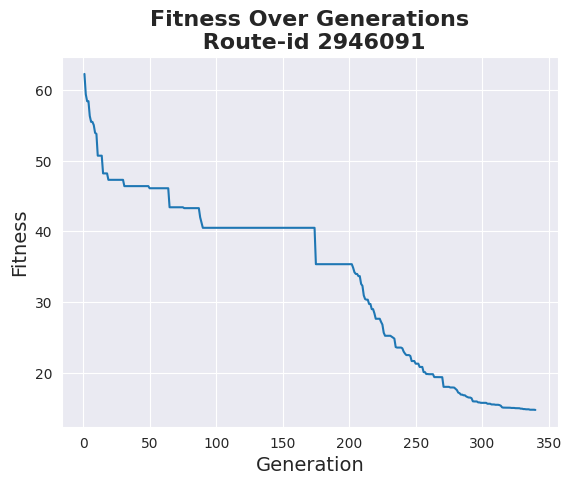

In [75]:
plotprettylineplot(history,2946091)

In [ ]:
plotprettylineplot(history,2946091)

In [78]:
(numberOfTrucks,customers,cost,demandForAll) = getData(2922001,customersDf,depotsDf,trucksDf)
best_solution,best_fitness,history = genetic_algorithm(100,numberOfTrucks,truckKg,truckVol,customers,cost,demandForAll,maxGenNumber=340,mutationRate=0.12)

population generated
Generation 256: Best Fitness = 35.4889
Generation 257: Best Fitness = 35.32889999999999
Generation 258: Best Fitness = 34.9554
Generation 259: Best Fitness = 34.9554
Generation 260: Best Fitness = 34.9554
Generation 261: Best Fitness = 34.801300000000005
Generation 262: Best Fitness = 34.5268
Generation 263: Best Fitness = 34.5268
Generation 264: Best Fitness = 34.25130000000001
Generation 265: Best Fitness = 34.25130000000001
Generation 266: Best Fitness = 34.25130000000001
Generation 267: Best Fitness = 34.22730000000001
Generation 268: Best Fitness = 34.122299999999996
Generation 269: Best Fitness = 34.122299999999996
Generation 270: Best Fitness = 34.0675
Generation 271: Best Fitness = 34.0675
Generation 272: Best Fitness = 34.0675
Generation 273: Best Fitness = 33.8391
Generation 274: Best Fitness = 33.6837
Generation 275: Best Fitness = 33.6781
Generation 276: Best Fitness = 33.4306
Generation 277: Best Fitness = 33.4306
Generation 278: Best Fitness = 33.4306

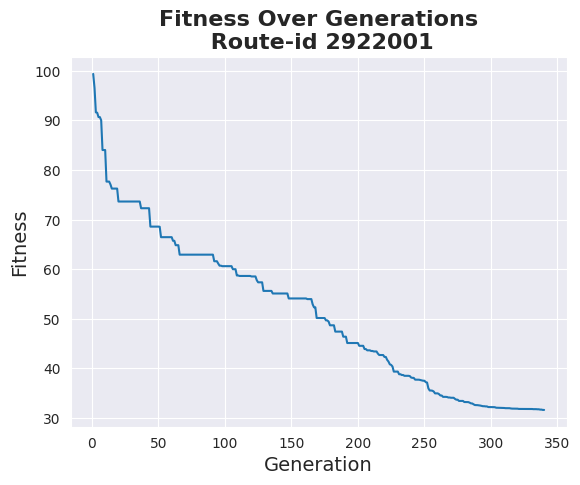

In [79]:
plotprettylineplot(history,2922001)

In [80]:
(numberOfTrucks,customers,cost,demandForAll) = getData(2939484,customersDf,depotsDf,trucksDf)
best_solution,best_fitness,history = genetic_algorithm(100,numberOfTrucks,truckKg,truckVol,customers,cost,demandForAll,maxGenNumber=340,mutationRate=0.12)

population generated
Generation 256: Best Fitness = 19.8742
Generation 257: Best Fitness = 19.5498
Generation 258: Best Fitness = 19.5498
Generation 259: Best Fitness = 19.5498
Generation 260: Best Fitness = 19.5498
Generation 261: Best Fitness = 19.5498
Generation 262: Best Fitness = 19.5498
Generation 263: Best Fitness = 19.5498
Generation 264: Best Fitness = 19.5498
Generation 265: Best Fitness = 19.5498
Generation 266: Best Fitness = 19.5498
Generation 267: Best Fitness = 19.5498
Generation 268: Best Fitness = 19.250899999999998
Generation 269: Best Fitness = 17.8325
Generation 270: Best Fitness = 17.8325
Generation 271: Best Fitness = 17.8325
Generation 272: Best Fitness = 17.8325
Generation 273: Best Fitness = 17.8325
Generation 274: Best Fitness = 17.8325
Generation 275: Best Fitness = 17.8325
Generation 276: Best Fitness = 17.8219
Generation 277: Best Fitness = 17.786799999999996
Generation 278: Best Fitness = 17.7778
Generation 279: Best Fitness = 17.7749
Generation 280: Best 

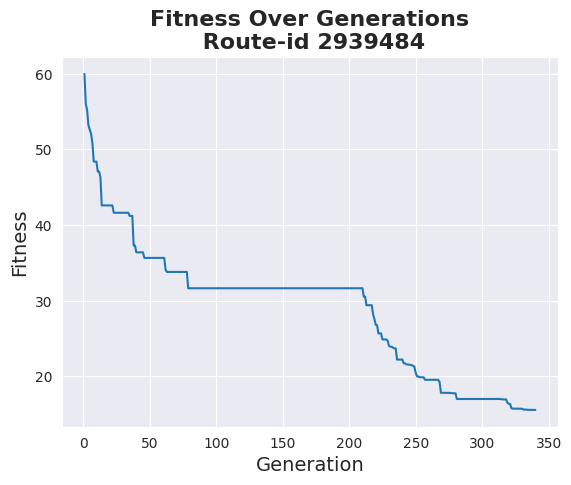

In [81]:
plotprettylineplot(history,2939484)

population generated
Generation 321: Best Fitness = 21.3674
Generation 322: Best Fitness = 21.3674
Generation 323: Best Fitness = 21.3674
Generation 324: Best Fitness = 21.3674
Generation 325: Best Fitness = 21.3674
Generation 326: Best Fitness = 21.3674
Generation 327: Best Fitness = 21.3674
Generation 328: Best Fitness = 21.3615
Generation 329: Best Fitness = 21.360699999999998
Generation 330: Best Fitness = 21.350599999999996
Generation 331: Best Fitness = 21.3442
Generation 332: Best Fitness = 21.331599999999998
Generation 333: Best Fitness = 20.964999999999996
Generation 334: Best Fitness = 20.964999999999996
Generation 335: Best Fitness = 20.964999999999996
Generation 336: Best Fitness = 20.964999999999996
Generation 337: Best Fitness = 20.964999999999996
Generation 338: Best Fitness = 20.964999999999996
Generation 339: Best Fitness = 20.964999999999996
Generation 340: Best Fitness = 20.964999999999996
Best Solution Found: [[0, 71, 97, 49, 59, 6, 68, 40, 76, 61, 10, 32, 82, 84, 9

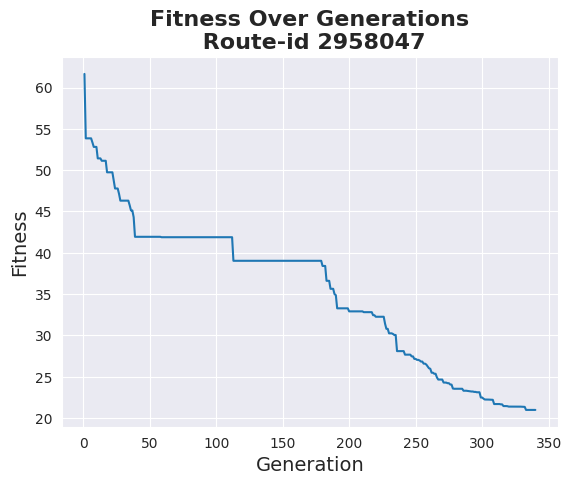

In [83]:
id = 2958047
(numberOfTrucks,customers,cost,demandForAll) = getData(id,customersDf,depotsDf,trucksDf)
best_solution,best_fitness,history = genetic_algorithm(100,numberOfTrucks,truckKg,truckVol,customers,cost,demandForAll,maxGenNumber=340,mutationRate=0.12)
plotprettylineplot(history,id)

In [85]:
def show(id):
  (numberOfTrucks,customers,cost,demandForAll) = getData(id,customersDf,depotsDf,trucksDf)
  best_solution,best_fitness,history = genetic_algorithm(100,numberOfTrucks,truckKg,truckVol,customers,cost,demandForAll,maxGenNumber=340,mutationRate=0.12)
  plotprettylineplot(history,id)

population generated
Generation 321: Best Fitness = 26.269199999999994
Generation 322: Best Fitness = 26.269199999999994
Generation 323: Best Fitness = 26.218699999999995
Generation 324: Best Fitness = 26.218699999999995
Generation 325: Best Fitness = 26.218699999999995
Generation 326: Best Fitness = 26.218699999999995
Generation 327: Best Fitness = 26.218699999999995
Generation 328: Best Fitness = 26.090500000000002
Generation 329: Best Fitness = 26.090500000000002
Generation 330: Best Fitness = 26.0735
Generation 331: Best Fitness = 26.0735
Generation 332: Best Fitness = 26.0735
Generation 333: Best Fitness = 26.0735
Generation 334: Best Fitness = 26.0735
Generation 335: Best Fitness = 26.0735
Generation 336: Best Fitness = 26.0735
Generation 337: Best Fitness = 26.0735
Generation 338: Best Fitness = 26.0735
Generation 339: Best Fitness = 25.8925
Generation 340: Best Fitness = 25.891199999999998
Best Solution Found: [[0, 40, 42, 16, 60, 34, 15, 105, 12, 19, 13, 35, 30, 84, 28, 124, 8

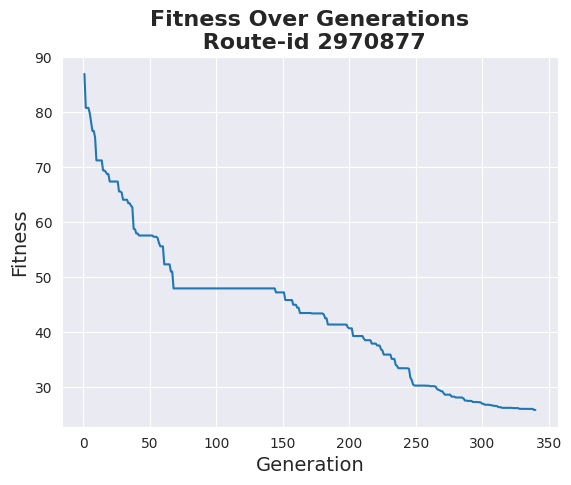

In [86]:
show(2970877)

In [87]:
routes

array([2946091, 2922001, 2939484, 2958047, 2970877, 2990001, 3005971,
       2604001, 3016355, 3027038, 3044702])

population generated
Generation 321: Best Fitness = 24.727000000000004
Generation 322: Best Fitness = 24.727000000000004
Generation 323: Best Fitness = 24.727000000000004
Generation 324: Best Fitness = 24.727000000000004
Generation 325: Best Fitness = 24.627000000000006
Generation 326: Best Fitness = 24.627000000000006
Generation 327: Best Fitness = 24.627000000000006
Generation 328: Best Fitness = 24.627000000000006
Generation 329: Best Fitness = 24.627000000000006
Generation 330: Best Fitness = 24.627000000000006
Generation 331: Best Fitness = 24.627000000000006
Generation 332: Best Fitness = 24.627000000000006
Generation 333: Best Fitness = 24.627000000000006
Generation 334: Best Fitness = 24.627000000000006
Generation 335: Best Fitness = 24.627000000000006
Generation 336: Best Fitness = 24.627000000000006
Generation 337: Best Fitness = 24.627000000000006
Generation 338: Best Fitness = 24.627000000000006
Generation 339: Best Fitness = 24.627000000000006
Generation 340: Best Fitness 

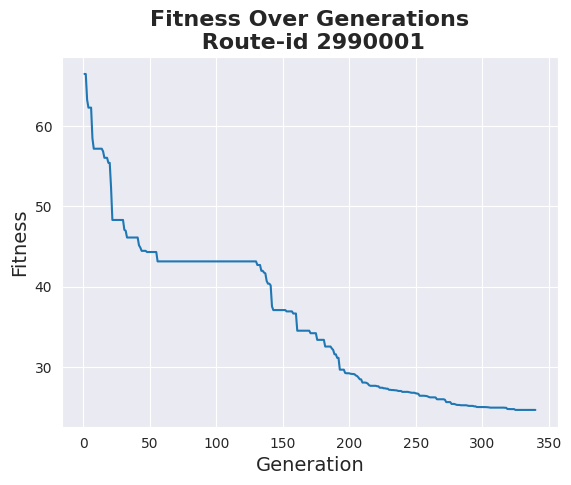

In [94]:
show(2990001)

population generated
Generation 321: Best Fitness = 23.581299999999995
Generation 322: Best Fitness = 23.581299999999995
Generation 323: Best Fitness = 23.573399999999996
Generation 324: Best Fitness = 23.573299999999996
Generation 325: Best Fitness = 23.573299999999996
Generation 326: Best Fitness = 23.566899999999997
Generation 327: Best Fitness = 23.5178
Generation 328: Best Fitness = 23.514199999999995
Generation 329: Best Fitness = 23.514199999999995
Generation 330: Best Fitness = 23.514199999999995
Generation 331: Best Fitness = 23.463999999999995
Generation 332: Best Fitness = 23.458699999999997
Generation 333: Best Fitness = 23.458699999999997
Generation 334: Best Fitness = 23.458699999999997
Generation 335: Best Fitness = 23.458699999999997
Generation 336: Best Fitness = 23.458699999999997
Generation 337: Best Fitness = 23.458699999999997
Generation 338: Best Fitness = 23.455699999999997
Generation 339: Best Fitness = 23.455699999999997
Generation 340: Best Fitness = 23.455699

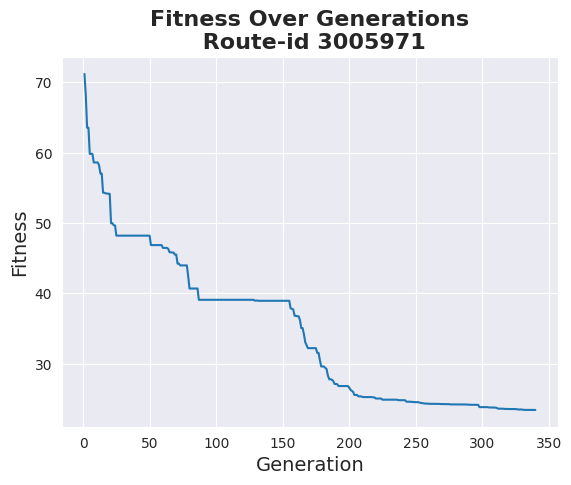

In [90]:
show(3005971)

population generated
Generation 321: Best Fitness = 19.8796
Generation 322: Best Fitness = 19.8796
Generation 323: Best Fitness = 19.8796
Generation 324: Best Fitness = 19.8796
Generation 325: Best Fitness = 19.8796
Generation 326: Best Fitness = 19.7212
Generation 327: Best Fitness = 19.7212
Generation 328: Best Fitness = 19.7212
Generation 329: Best Fitness = 19.7212
Generation 330: Best Fitness = 19.707
Generation 331: Best Fitness = 19.707
Generation 332: Best Fitness = 19.7062
Generation 333: Best Fitness = 19.7018
Generation 334: Best Fitness = 19.6802
Generation 335: Best Fitness = 19.6497
Generation 336: Best Fitness = 19.6395
Generation 337: Best Fitness = 19.6395
Generation 338: Best Fitness = 19.6331
Generation 339: Best Fitness = 19.6331
Generation 340: Best Fitness = 19.6189
Best Solution Found: [[0, 112, 13, 30, 34, 92, 18, 105, 89, 109, 97, 53, 19, 36, 55, 77, 26, 73, 93, 114, 41, 52, 66, 90, 2, 61, 91, 27, 42, 72, 7, 95, 3, 21, 46, 47, 6, 81, 67, 65, 63, 51, 71, 22, 104

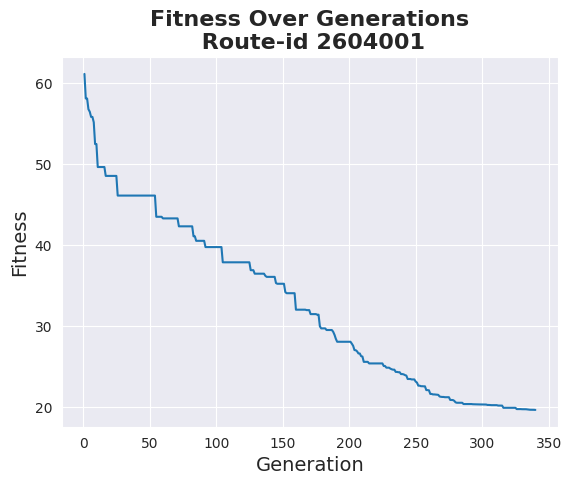

In [91]:
show(2604001)

In [ ]:
show(3016355)

population generated
Generation 321: Best Fitness = 18.105699999999995
Generation 322: Best Fitness = 18.105699999999995
Generation 323: Best Fitness = 17.956799999999994
Generation 324: Best Fitness = 17.956799999999994
Generation 325: Best Fitness = 17.956799999999994
Generation 326: Best Fitness = 17.956799999999994
Generation 327: Best Fitness = 17.956799999999994
Generation 328: Best Fitness = 17.956499999999995
Generation 329: Best Fitness = 17.956499999999995
Generation 330: Best Fitness = 17.956499999999995
Generation 331: Best Fitness = 17.956499999999995
Generation 332: Best Fitness = 17.946399999999997
Generation 333: Best Fitness = 17.937999999999995
Generation 334: Best Fitness = 17.937999999999995
Generation 335: Best Fitness = 17.937999999999995
Generation 336: Best Fitness = 17.899099999999994
Generation 337: Best Fitness = 17.837999999999994
Generation 338: Best Fitness = 17.837999999999994
Generation 339: Best Fitness = 17.837999999999994
Generation 340: Best Fitness 

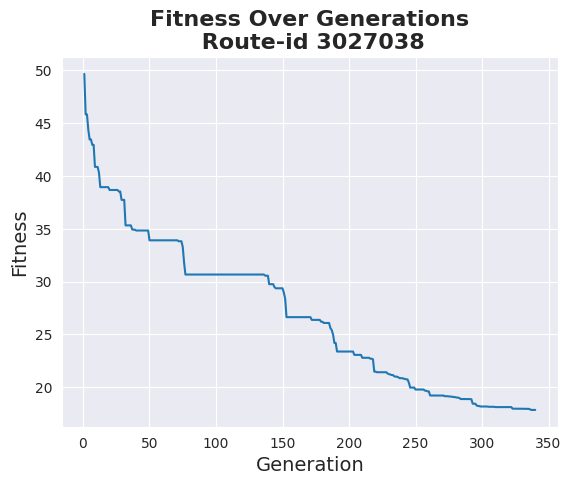

In [95]:
show(3027038)

population generated
Generation 321: Best Fitness = 15.213300000000002
Generation 322: Best Fitness = 15.213300000000002
Generation 323: Best Fitness = 15.213300000000002
Generation 324: Best Fitness = 15.213300000000002
Generation 325: Best Fitness = 15.213300000000002
Generation 326: Best Fitness = 15.213300000000002
Generation 327: Best Fitness = 15.213300000000002
Generation 328: Best Fitness = 15.213300000000002
Generation 329: Best Fitness = 15.203400000000002
Generation 330: Best Fitness = 15.186499999999999
Generation 331: Best Fitness = 15.186499999999999
Generation 332: Best Fitness = 15.186499999999999
Generation 333: Best Fitness = 15.186499999999999
Generation 334: Best Fitness = 15.186499999999999
Generation 335: Best Fitness = 15.186499999999999
Generation 336: Best Fitness = 15.186499999999999
Generation 337: Best Fitness = 15.186499999999999
Generation 338: Best Fitness = 15.186499999999999
Generation 339: Best Fitness = 15.186499999999999
Generation 340: Best Fitness 

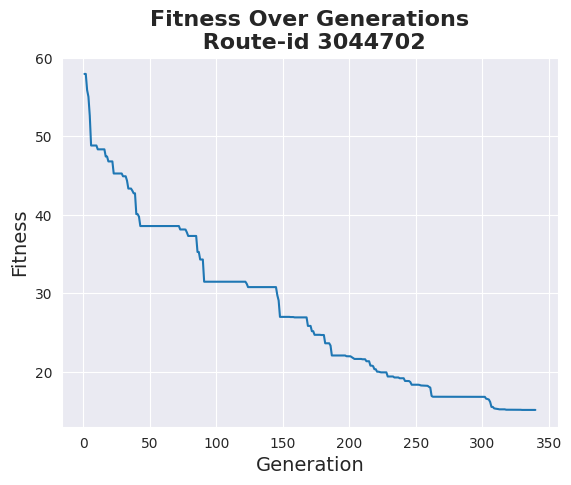

In [96]:
show(3044702)